In [1]:
import pandas as pd
import tensorflow as tf
from keras import layers
import keras
import os
from keras.regularizers import L1, L2
from transformers import ViTFeatureExtractor, DefaultDataCollator, TFViTForImageClassification, create_optimizer, TFViTModel
from keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping
import matplotlib.pyplot as plt
from scipy.spatial import procrustes
import numpy as np
import warnings
import sys 
import datasets
import cv2

In [2]:
def load_images_from_folder_rgb(folder):
    images = []
    print(folder)
    # for filename in glob.glob(os.path.join(folder+'/*.jpg')):
    for filename in sorted(os.listdir(folder)):
        # print(filename)
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(cv2.resize(img,(224,224)))
    return np.array(images)

In [3]:
img_360_rgb = load_images_from_folder_rgb("D:\\IU\\Classes\\Spring 24\\Rock 360 Study\\360 Rocks") ##Loading the original 360 dataset for prediction at the end
img_120_rgb = load_images_from_folder_rgb("D:\\IU\\Classes\\Spring 24\\Rock 360 Study\\120 Rocks") ##Loading the original 120 dataset for prediction at the end

D:\IU\Classes\Spring 24\Rock 360 Study\360 Rocks
D:\IU\Classes\Spring 24\Rock 360 Study\120 Rocks


In [4]:
flattened_image_rgb = img_360_rgb.reshape(360, -1)

In [5]:
def create_image_folder_dataset(root_path):
    """creates `Dataset` from image folder structure"""
    # get class names by folders names
    _CLASS_NAMES= os.listdir(root_path)
    # defines `datasets` features`
    features=datasets.Features({
                      "img": datasets.Image(),
                      "label": datasets.features.ClassLabel(names=_CLASS_NAMES),
                  })
    # temp list holding datapoints for creation
    img_data_files=[]
    label_data_files=[]
    # load images into list for creation
    for img_class in sorted(os.listdir(root_path)):
        for img in os.listdir(os.path.join(root_path,img_class)):
            path_=os.path.join(root_path,img_class,img)
            img_data_files.append(path_)
            label_data_files.append(img_class)
    # create dataset
    ds = datasets.Dataset.from_dict({"img":img_data_files,"label":label_data_files},features=features)
    return ds

In [6]:
rocks360_ds = create_image_folder_dataset("D:\\IU\\Classes\\Spring 24\\Rock 360 Study\\360 Split 30")

In [7]:
img_class_labels = rocks360_ds.features["label"].names

In [8]:
rocks360_labels = img_class_labels

In [9]:
Y_120 = np.loadtxt("D:\\IU\\Classes\\Spring 24\\Rock 360 Study\\mds_120.txt")
Y_360 = np.loadtxt("D:\\IU\\Classes\\Spring 24\\Rock 360 Study\\mds_360.txt")

In [10]:
img_360_rgb_tr = tf.transpose(img_360_rgb, perm=[0, 3, 1, 2])
img_120_rgb_tr = tf.transpose(img_120_rgb, perm=[0, 3, 1, 2])

In [11]:
mds_model = keras.models.load_model('D:\\IU\\Classes\\Spring 24\\Rock 360 Study\\new_mds_30_224_huge_patch_14_25_30_30_3e-05_0.1_0_3_.keras')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Laptop GPU, compute capability 8.6


In [12]:
activations_360 = mds_model.predict(img_360_rgb_tr)
activations_120 = mds_model.predict(img_120_rgb_tr)

4/4 [==============================] - 6s 2s/step


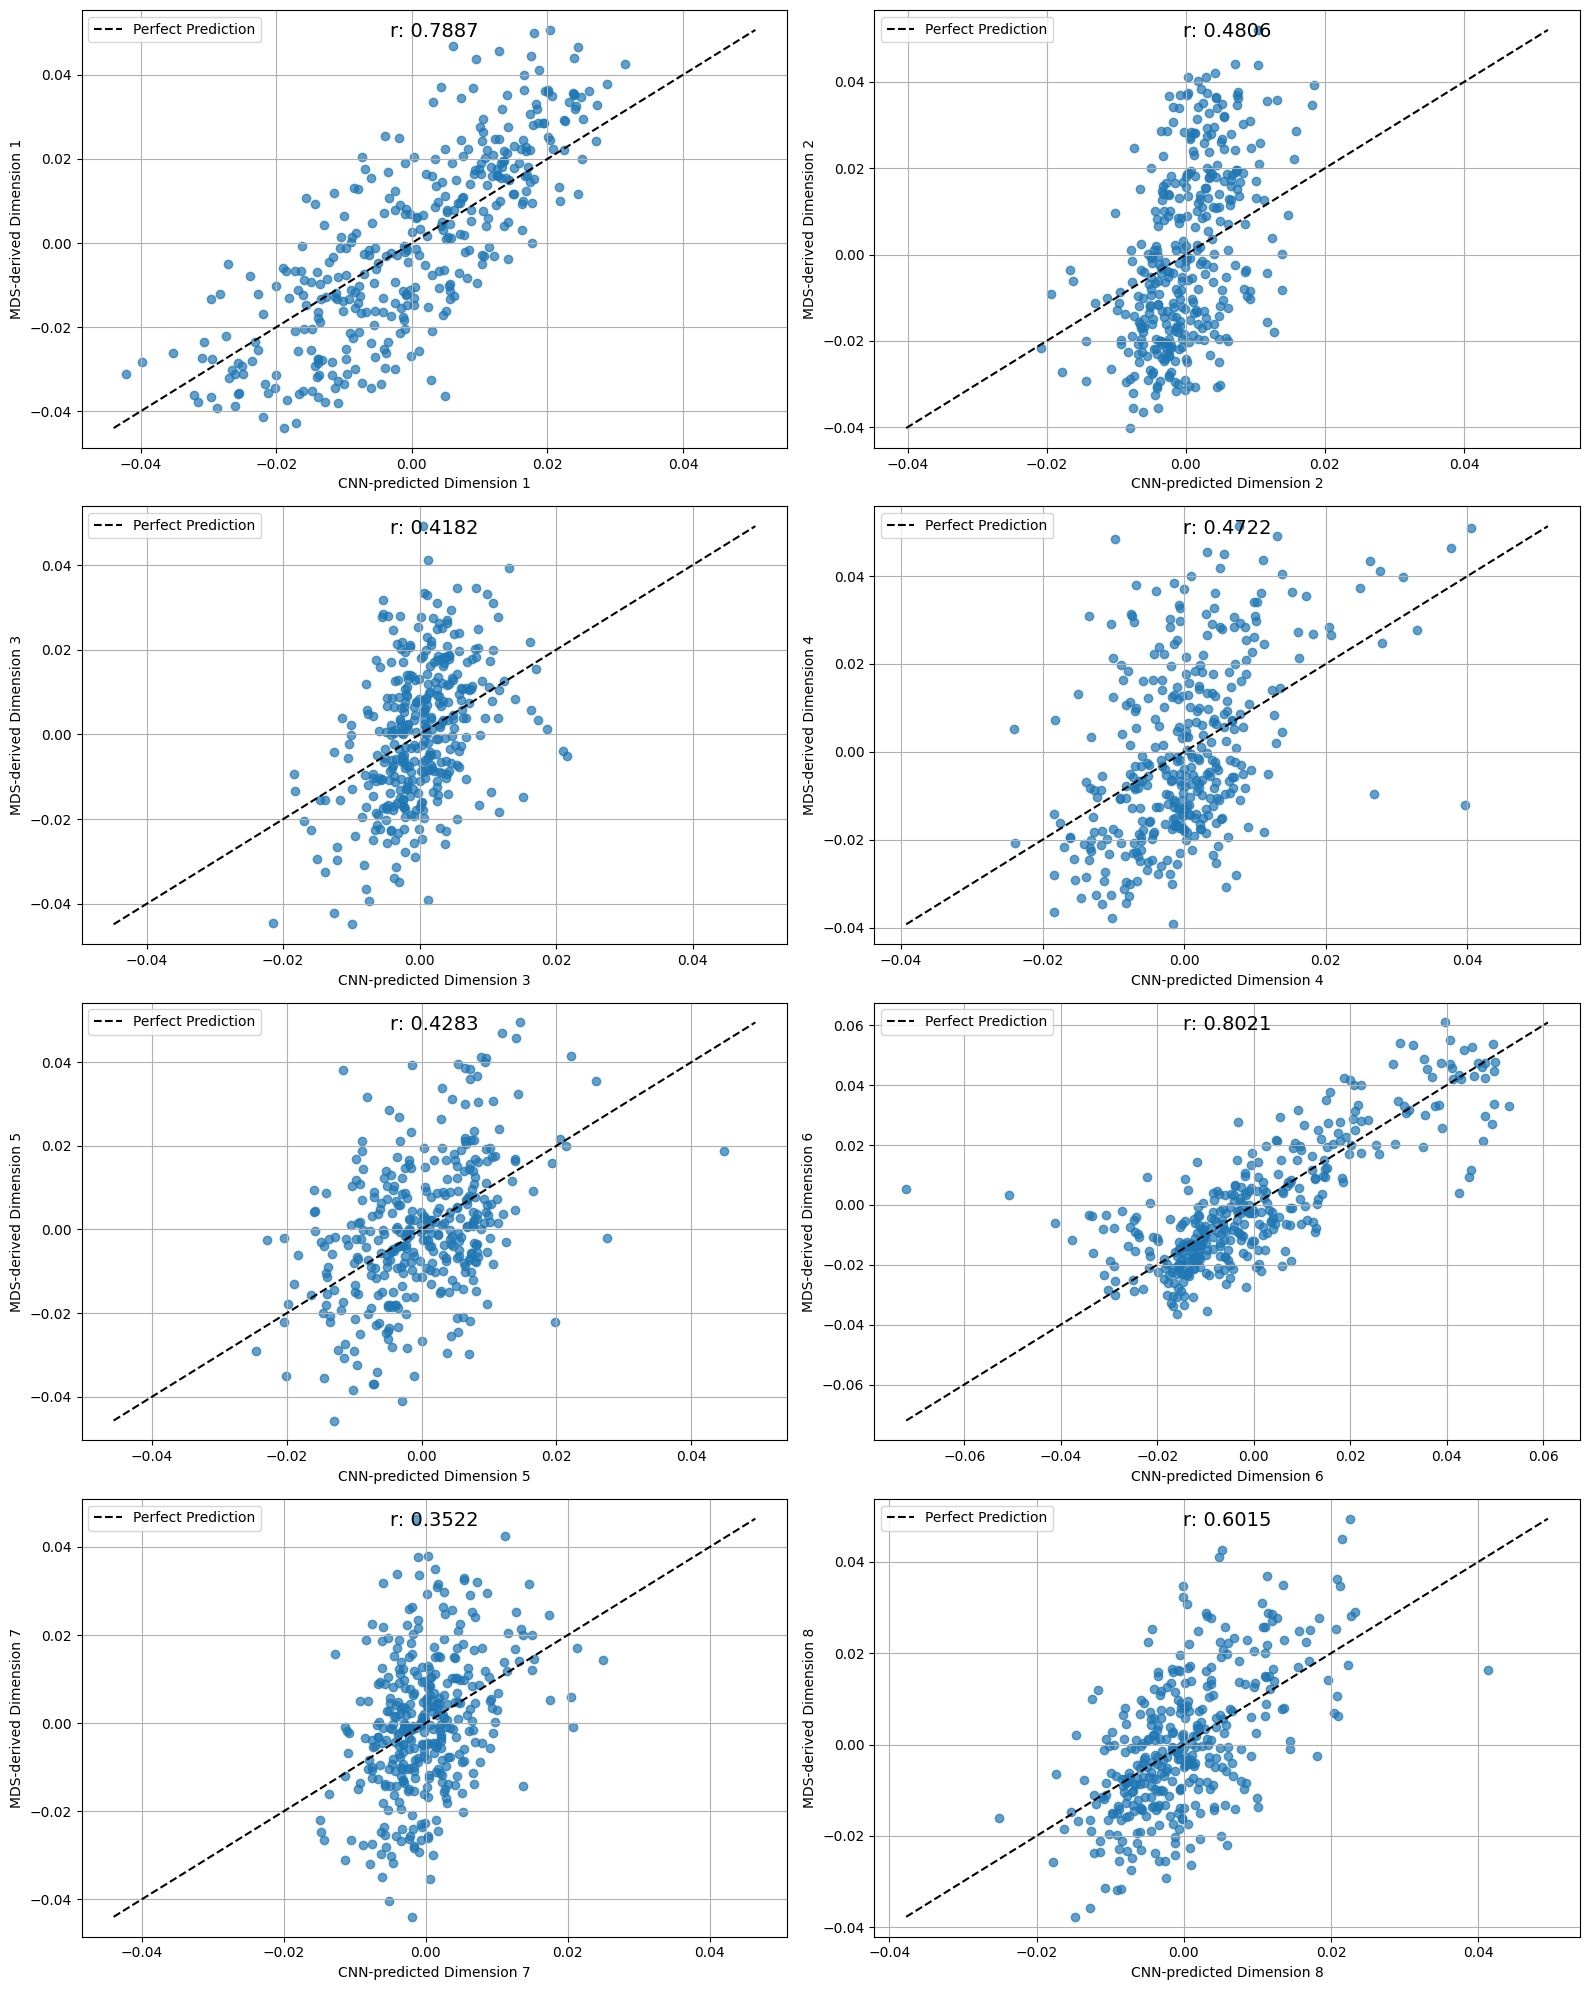

In [13]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from scipy.stats import pearsonr
from PIL import Image

images = img_360_rgb

mtx1, mtx2, disparity = procrustes(Y_360, activations_360)

mds_cnn_coordinates = mtx2
mds_actual_coordinates = mtx1 

scaled_images = images

correlation_coefficients = [pearsonr(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i])[0] for i in range(8)]

# Create subplots for each dimension
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    
    ax.scatter(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i], alpha=0.7)
    
    ax.plot(np.linspace(min(mds_actual_coordinates[:, i].min(), mds_cnn_coordinates[:, i].min()),
                        max(mds_actual_coordinates[:, i].max(), mds_cnn_coordinates[:, i].max()), 100),
            np.linspace(min(mds_actual_coordinates[:, i].min(), mds_cnn_coordinates[:, i].min()),
                        max(mds_actual_coordinates[:, i].max(), mds_cnn_coordinates[:, i].max()), 100),
            'k--', label='Perfect Prediction')
    
    ax.set_xlabel(f'CNN-predicted Dimension {i+1}')
    ax.set_ylabel(f'MDS-derived Dimension {i+1}')
    ax.legend()
    ax.grid(True)
    
    ax.text(0.5, 0.95, f"r: {correlation_coefficients[i]:.4f}", ha='center', va='center', transform=ax.transAxes, fontsize=14)

plt.tight_layout()
plt.show()

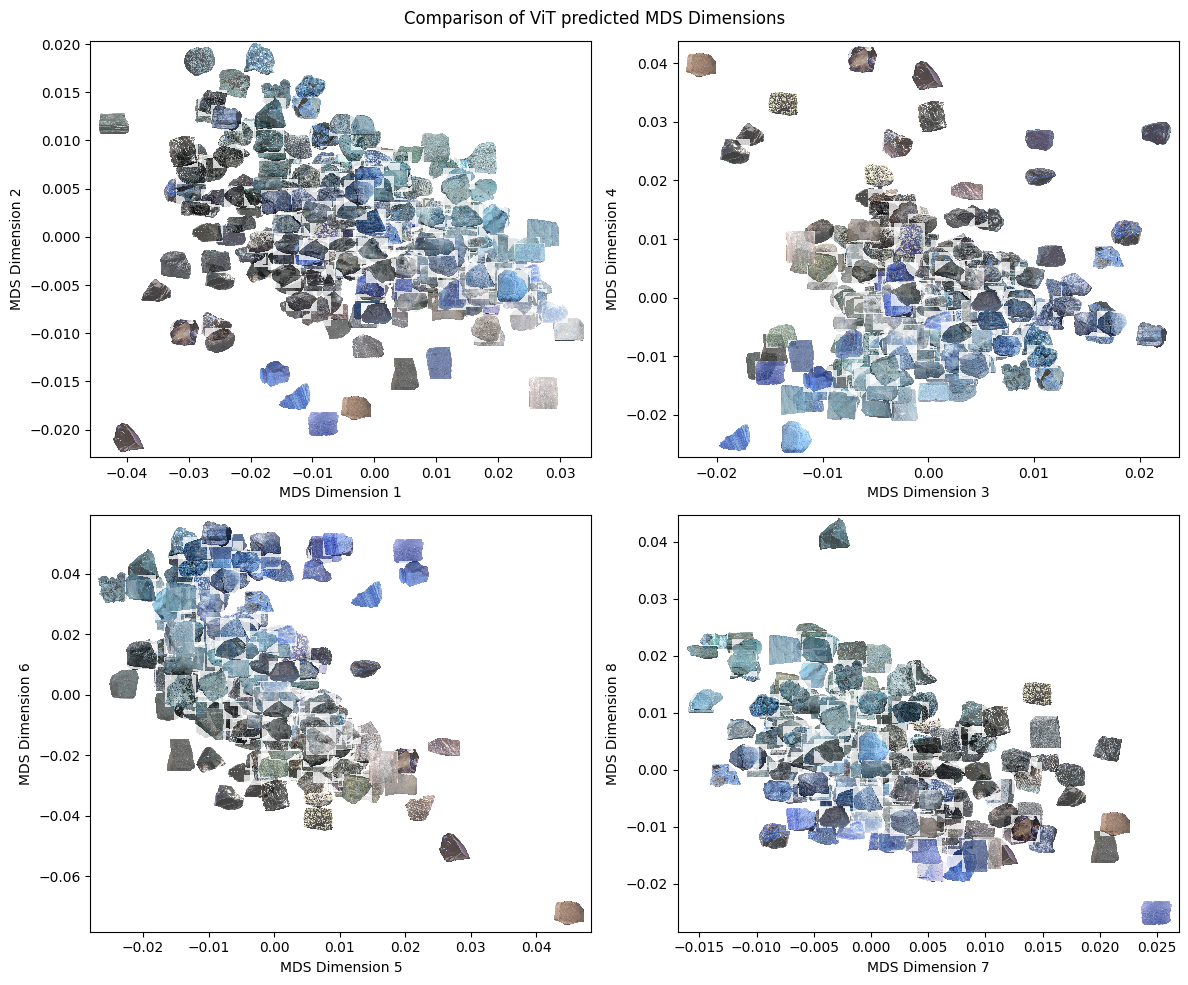

In [22]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from PIL import Image

images = img_360_rgb

mtx1, mtx2, disparity = procrustes(Y_360, activations_360)

mds_coordinates = mtx2

scaled_images = images

def crop_image_color_threshold(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Define lower and upper bounds for white color in BGR format
    lower_white = np.array([200, 200, 200])
    upper_white = np.array([255, 255, 255])
    
    # Create a mask based on the color threshold
    mask = cv2.inRange(img, lower_white, upper_white)
    
    # Invert the mask to get the regions that are not white
    mask = cv2.bitwise_not(mask)
    
    # Find contours of the non-white regions
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get the bounding box of the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image using the bounding box
    cropped_img = img[y:y+h, x:x+w]
    
    return cropped_img


# Create subplots for different pairs of dimensions
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Pairs of dimensions: (0, 1), (2, 3), (4, 5), (6, 7)
dimension_pairs = [(0, 1), (2, 3), (4, 5), (6, 7)]

for i, ax in enumerate(axes.flatten()):
    dimension_x, dimension_y = dimension_pairs[i]
    
    # Scatter plot of MDS coordinates
    ax.scatter(mds_coordinates[:, dimension_x], mds_coordinates[:, dimension_y], alpha=0.01)
    
    # Function to display resized images
    def plot_resized_image(img, x, y, ax):
        img_copy = crop_image_color_threshold(img)
        imagebox = OffsetImage(img_copy, zoom=0.1, alpha = 0.75) 
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)
        
    # Plot each image at its respective MDS coordinates
    for j, (x, y) in enumerate(zip(mds_coordinates[:, dimension_x], mds_coordinates[:, dimension_y])):
        image = scaled_images[j]  # Get the image at index j
        plot_resized_image(image, x, y, ax)
    
    ax.set_xlabel(f'MDS Dimension {dimension_x+1}')
    ax.set_ylabel(f'MDS Dimension {dimension_y+1}')

plt.suptitle(f'Comparison of ViT predicted MDS Dimensions')
plt.tight_layout()
plt.savefig("360 Comp plot.png", dpi=300)
plt.show()

In [19]:
correlation_coefficients

[0.7887165460848207,
 0.4806234875497376,
 0.41822684710973823,
 0.47221038200654825,
 0.4283280911925402,
 0.8021390824568196,
 0.352224342131303,
 0.6014711381225398]

In [63]:
np.mean(correlation_coefficients)

0.5429924895817559

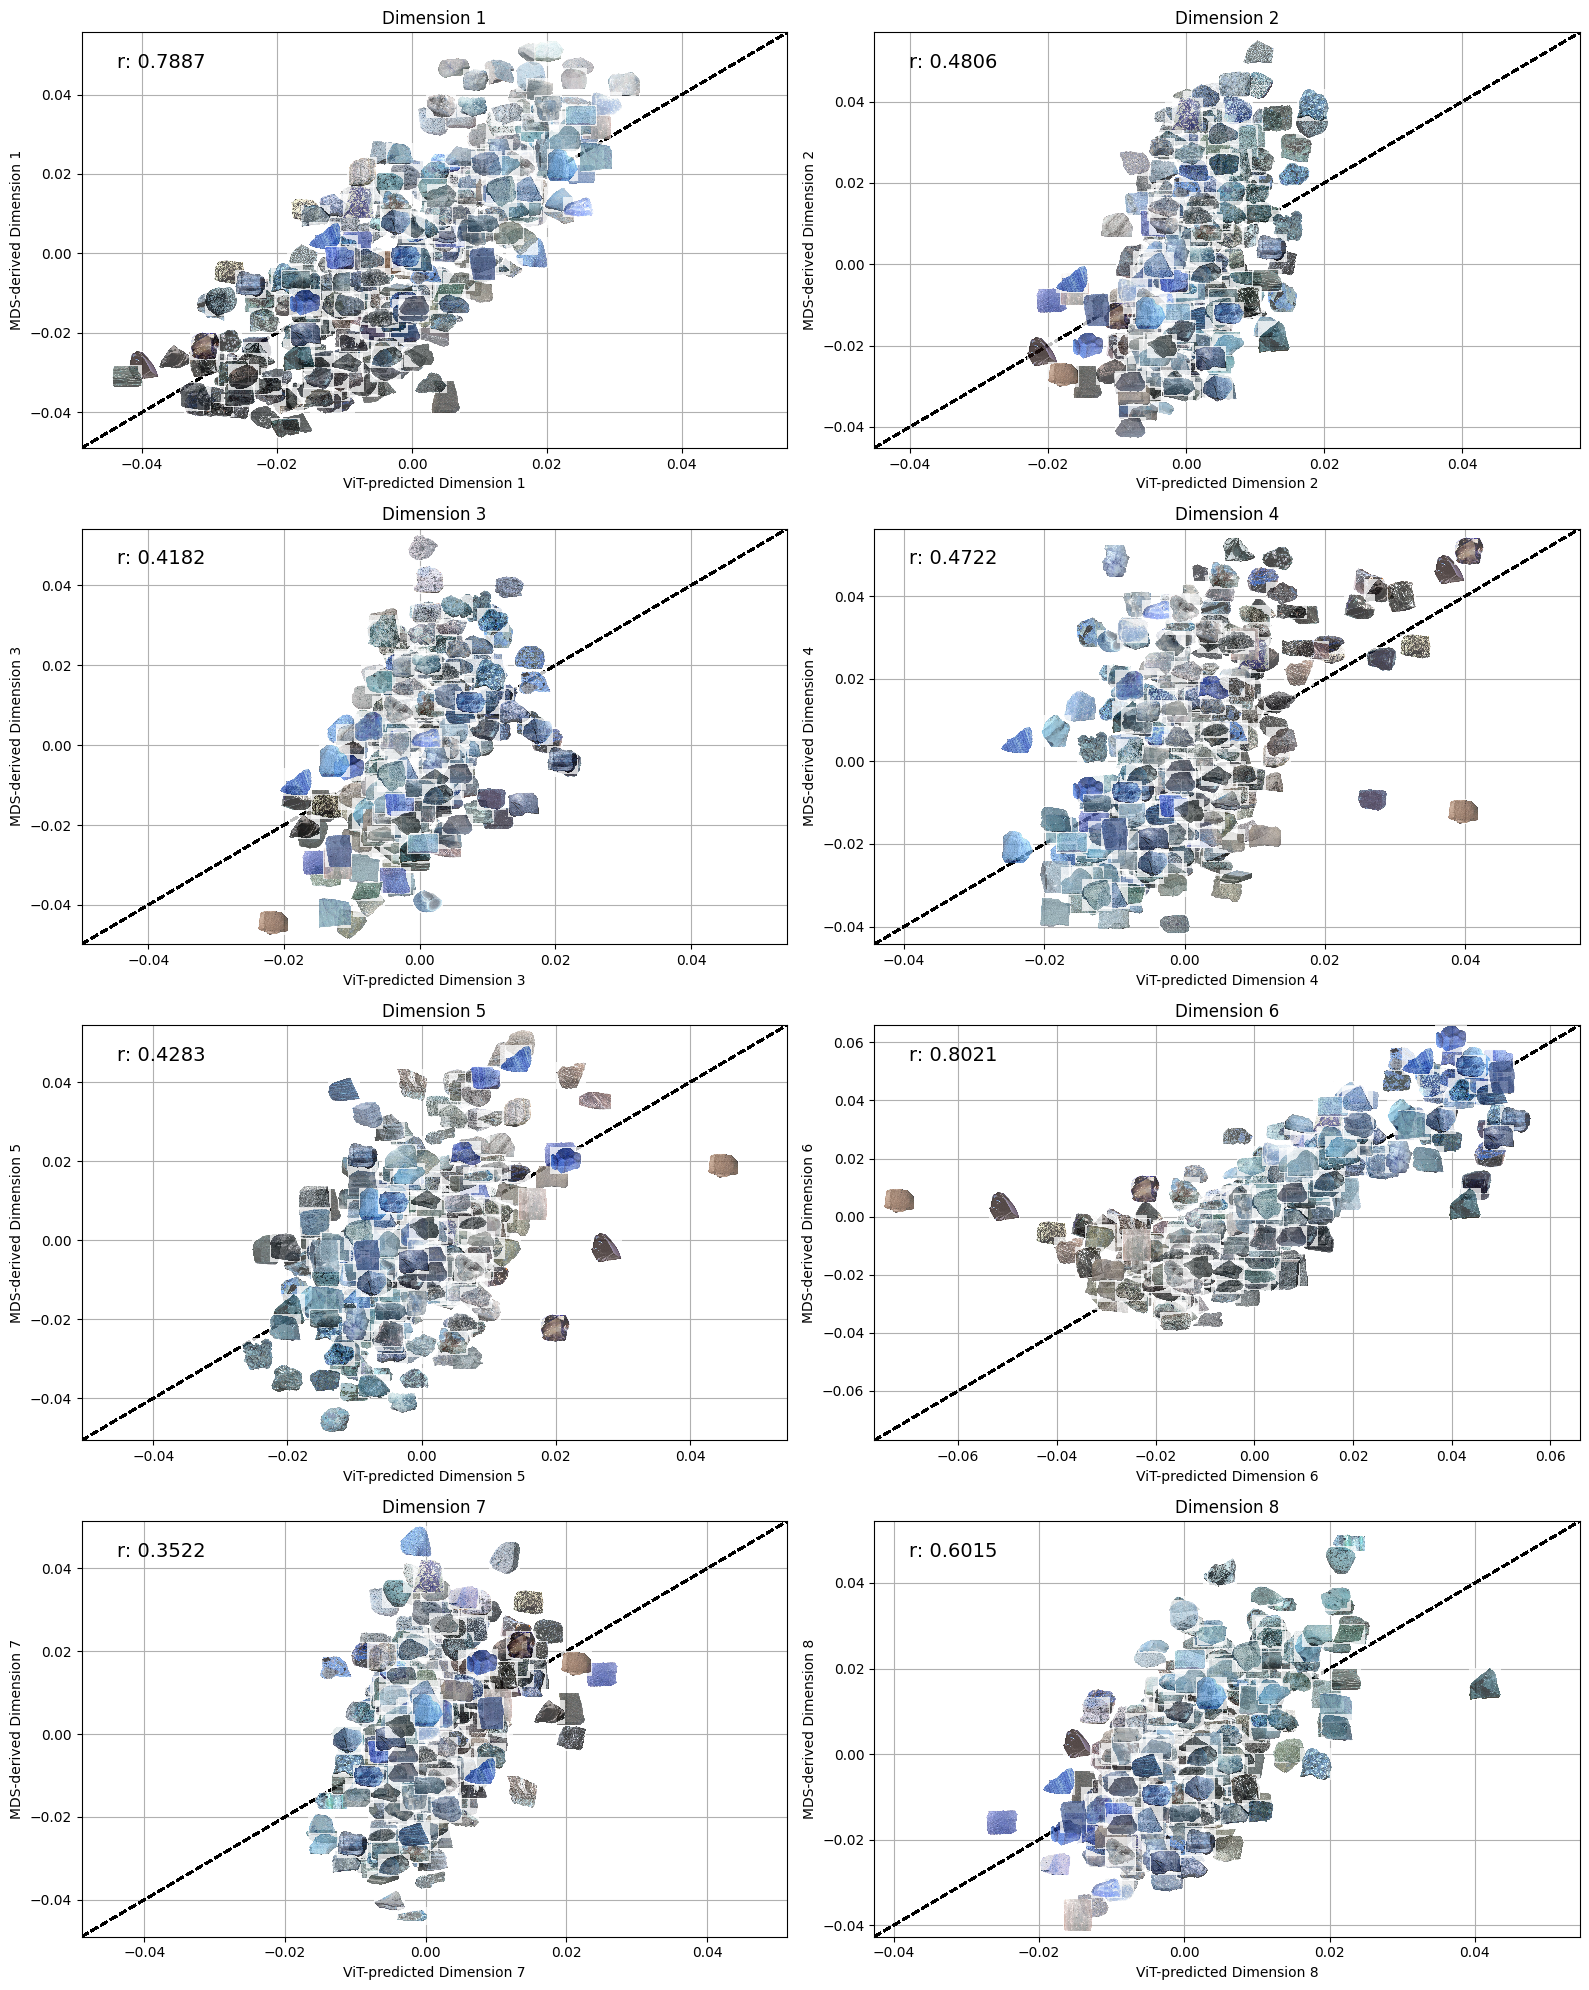

In [64]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from scipy.stats import pearsonr

def crop_image(img):
    # Find non-white pixels along rows
    non_white_rows = np.where(~np.all(img == 255, axis=1))[0]
    # Find non-white pixels along columns
    non_white_cols = np.where(~np.all(img == 255, axis=0))[0]
    # Crop the image using the non-white pixels
    cropped_img = img[non_white_rows.min():non_white_rows.max()+1, non_white_cols.min():non_white_cols.max()+1]
    return cropped_img

def crop_image_color_threshold(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Define lower and upper bounds for white color in BGR format
    lower_white = np.array([200, 200, 200])
    upper_white = np.array([255, 255, 255])
    
    # Create a mask based on the color threshold
    mask = cv2.inRange(img, lower_white, upper_white)
    
    # Invert the mask to get the regions that are not white
    mask = cv2.bitwise_not(mask)
    
    # Find contours of the non-white regions
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get the bounding box of the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image using the bounding box
    cropped_img = img[y:y+h, x:x+w]
    
    return cropped_img

def plot_images_with_coordinates(images, cnn_coordinates, actual_coordinates, correlation_coefficients):
    num_dimensions = cnn_coordinates.shape[1]
    num_images = images.shape[0]
    
    fig, axes = plt.subplots(4, 2, figsize=(16, 20))
    axes = axes.flatten()

    for dim_index in range(num_dimensions):
        ax = axes[dim_index]
        ax.set_title(f"Dimension {dim_index+1}")

        # Get the coordinates for the current dimension
        cnn_coords_dim = cnn_coordinates[:, dim_index]
        actual_coords_dim = actual_coordinates[:, dim_index]

        ax.set_xlabel(f'ViT-predicted Dimension {dim_index+1}')
        ax.set_ylabel(f'MDS-derived Dimension {dim_index+1}')
        ax.grid(True)

        # Dynamically adjust x and y limits based on MDS coordinates
        x_min, x_max = min(cnn_coords_dim.min(), actual_coords_dim.min())-0.005, max(cnn_coords_dim.max(), actual_coords_dim.max())+0.005
        y_min, y_max = min(cnn_coords_dim.min(), actual_coords_dim.min())-0.005, max(cnn_coords_dim.max(), actual_coords_dim.max())+0.005
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # Plot images with coordinates for the current dimension
        for image_index in range(num_images):
            x = cnn_coords_dim[image_index]
            y = actual_coords_dim[image_index]
            img = images[image_index]

            # Crop the image to remove white borders
            img = crop_image(img)

            # Display the image
            imagebox = OffsetImage(img, zoom=0.1, alpha = 0.75)  # Adjust the zoom factor as needed
            ab = AnnotationBbox(imagebox, (x, y), frameon=False)
            ax.add_artist(ab)
            
            # Add a line at 45 degrees
            ax.plot([x_min, x_max], [y_min, y_max], color='black', linestyle='--')

        # Adjusted position of text to top-left corner
        ax.text(0.05, 0.95, f"r: {correlation_coefficients[dim_index]:.4f}", ha='left', va='top', transform=ax.transAxes, fontsize=14)

    plt.tight_layout()
    plt.savefig("360 Corr plot.png", dpi=300)
    plt.show()

# Placeholder for images (replace this with your actual image data)
images = img_360_rgb

# Placeholder for correlation coefficients (replace this with your actual data)
correlation_coefficients = [pearsonr(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i])[0] for i in range(8)]

# Plotting images with coordinates
plot_images_with_coordinates(images, mds_cnn_coordinates, mds_actual_coordinates, correlation_coefficients)


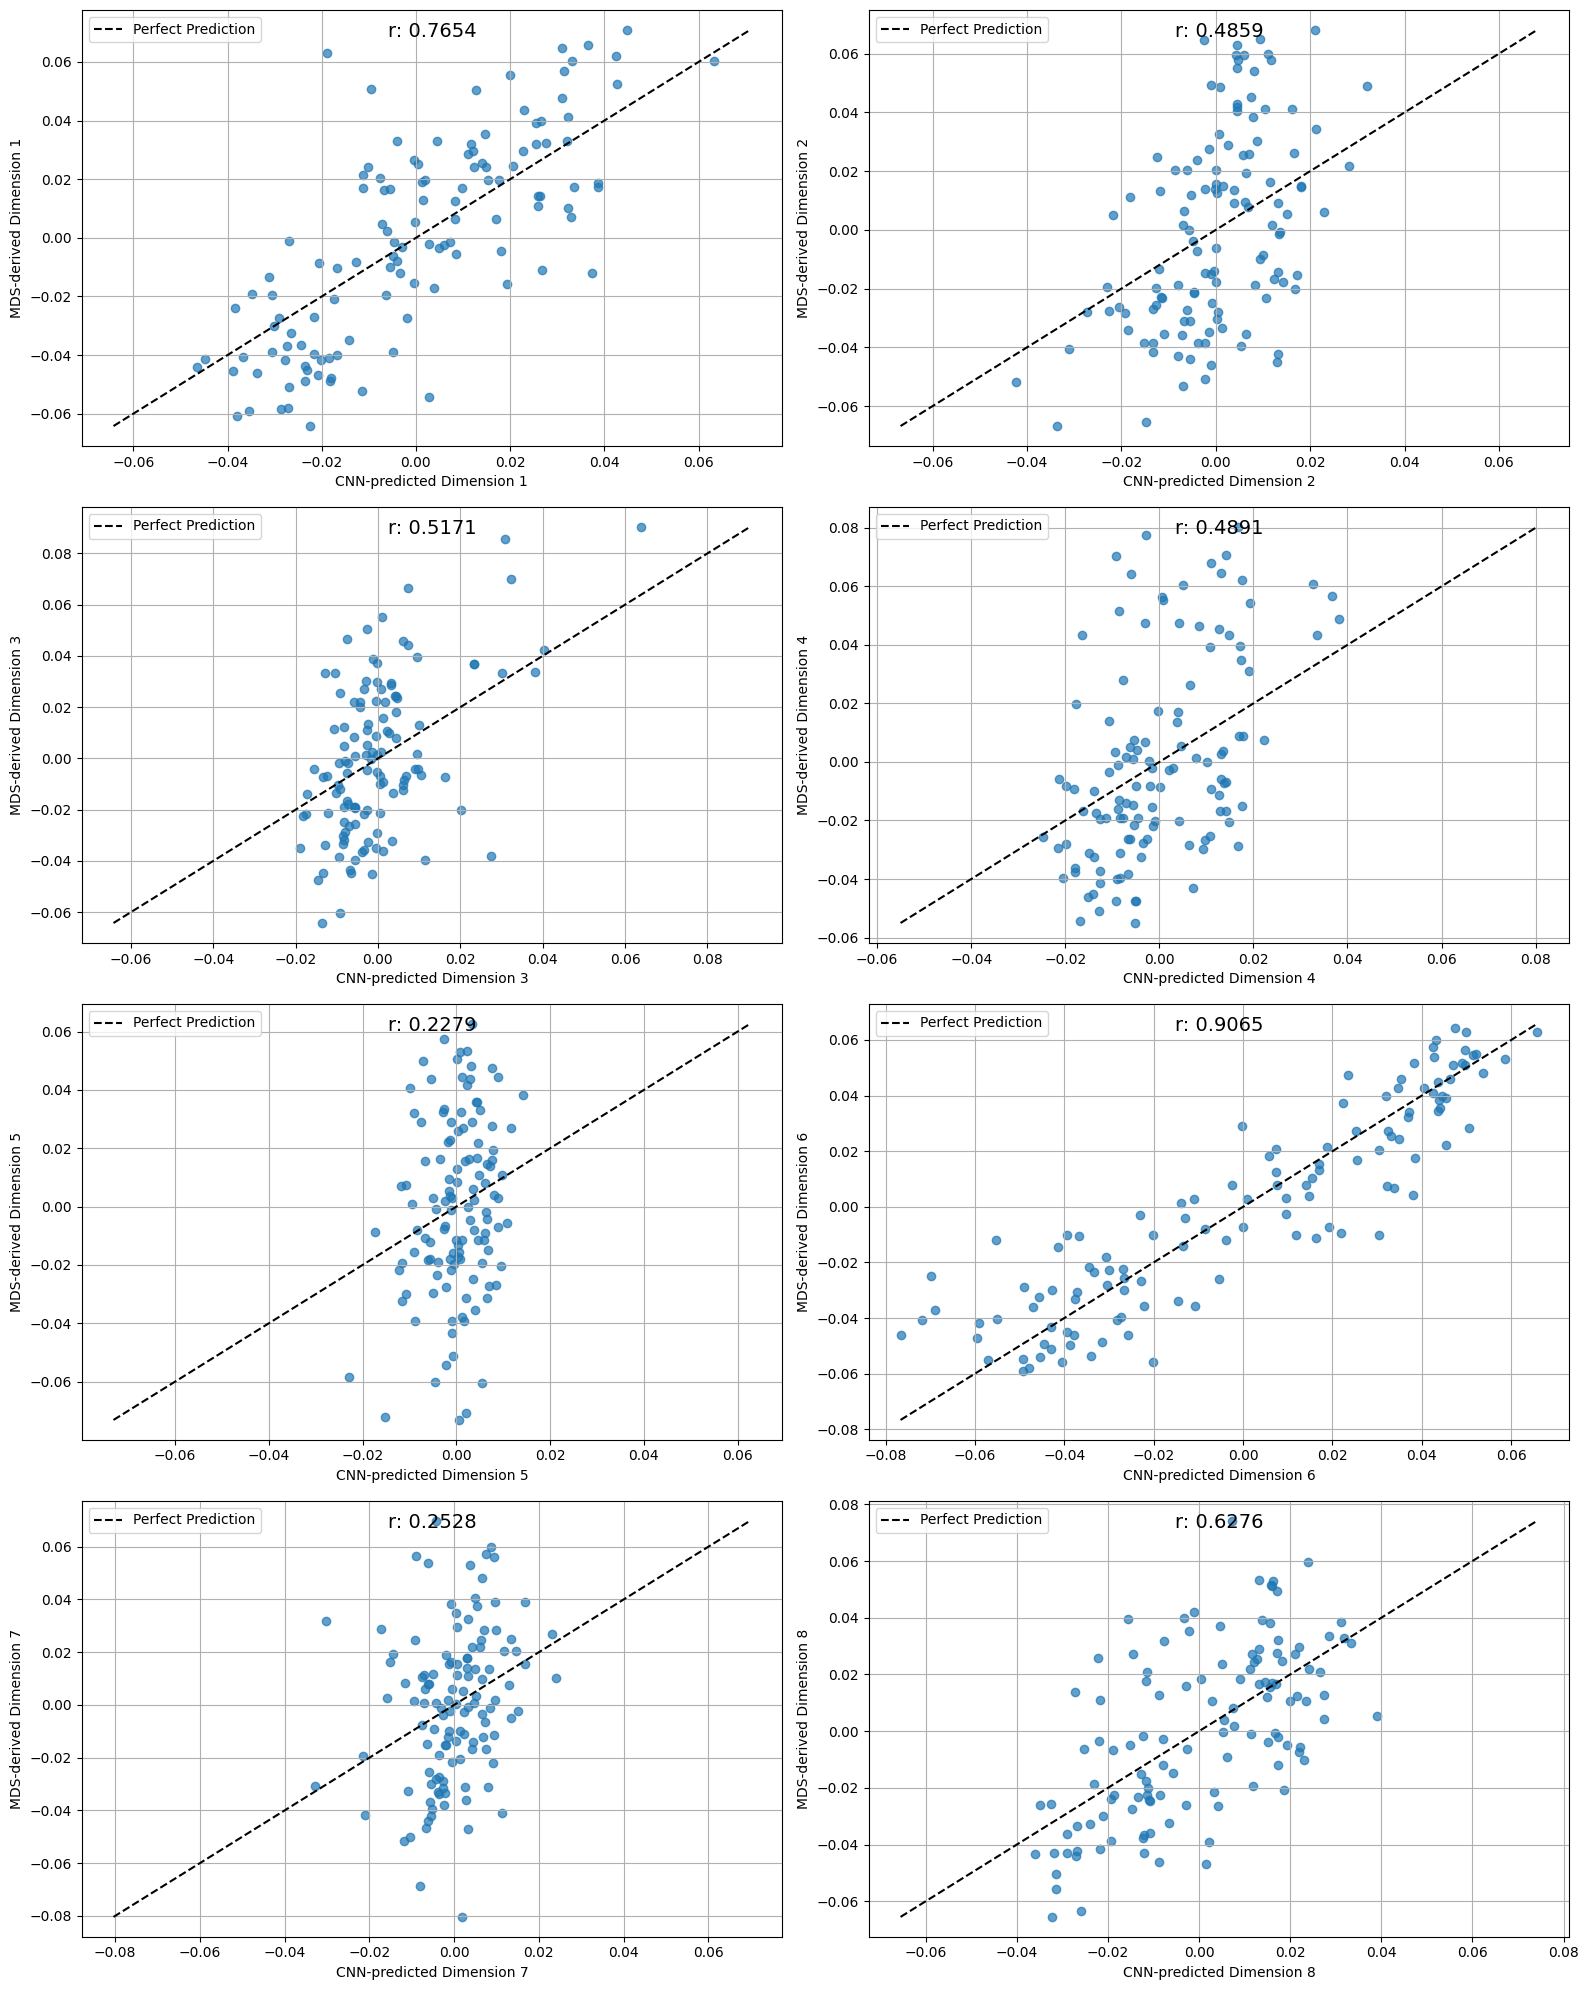

In [20]:
images = img_120_rgb

mtx1, mtx2, disparity = procrustes(Y_120, activations_120)

mds_cnn_coordinates = mtx2
mds_actual_coordinates = mtx1 

scaled_images = images

# Calculate Pearson correlation coefficients for each dimension
correlation_coefficients = [pearsonr(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i])[0] for i in range(8)]

# Create subplots for each dimension
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
# fig.suptitle("Scatterplots of CNN-predicted dimensions against MDS derived dimensions")
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    
    ax.scatter(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i], alpha=0.7)
    
    ax.plot(np.linspace(min(mds_actual_coordinates[:, i].min(), mds_cnn_coordinates[:, i].min()),
                        max(mds_actual_coordinates[:, i].max(), mds_cnn_coordinates[:, i].max()), 100),
            np.linspace(min(mds_actual_coordinates[:, i].min(), mds_cnn_coordinates[:, i].min()),
                        max(mds_actual_coordinates[:, i].max(), mds_cnn_coordinates[:, i].max()), 100),
            'k--', label='Perfect Prediction')
    
    ax.set_xlabel(f'CNN-predicted Dimension {i+1}')
    ax.set_ylabel(f'MDS-derived Dimension {i+1}')
    ax.legend()
    ax.grid(True)
    
    ax.text(0.5, 0.95, f"r: {correlation_coefficients[i]:.4f}", ha='center', va='center', transform=ax.transAxes, fontsize=14)

plt.tight_layout()
plt.show()

In [55]:
correlation_coefficients

[0.7653694224470237,
 0.4858768825382819,
 0.5170929073055314,
 0.4890541229457338,
 0.22789160195071345,
 0.9065170435416384,
 0.2527630732721543,
 0.6276172928049624]

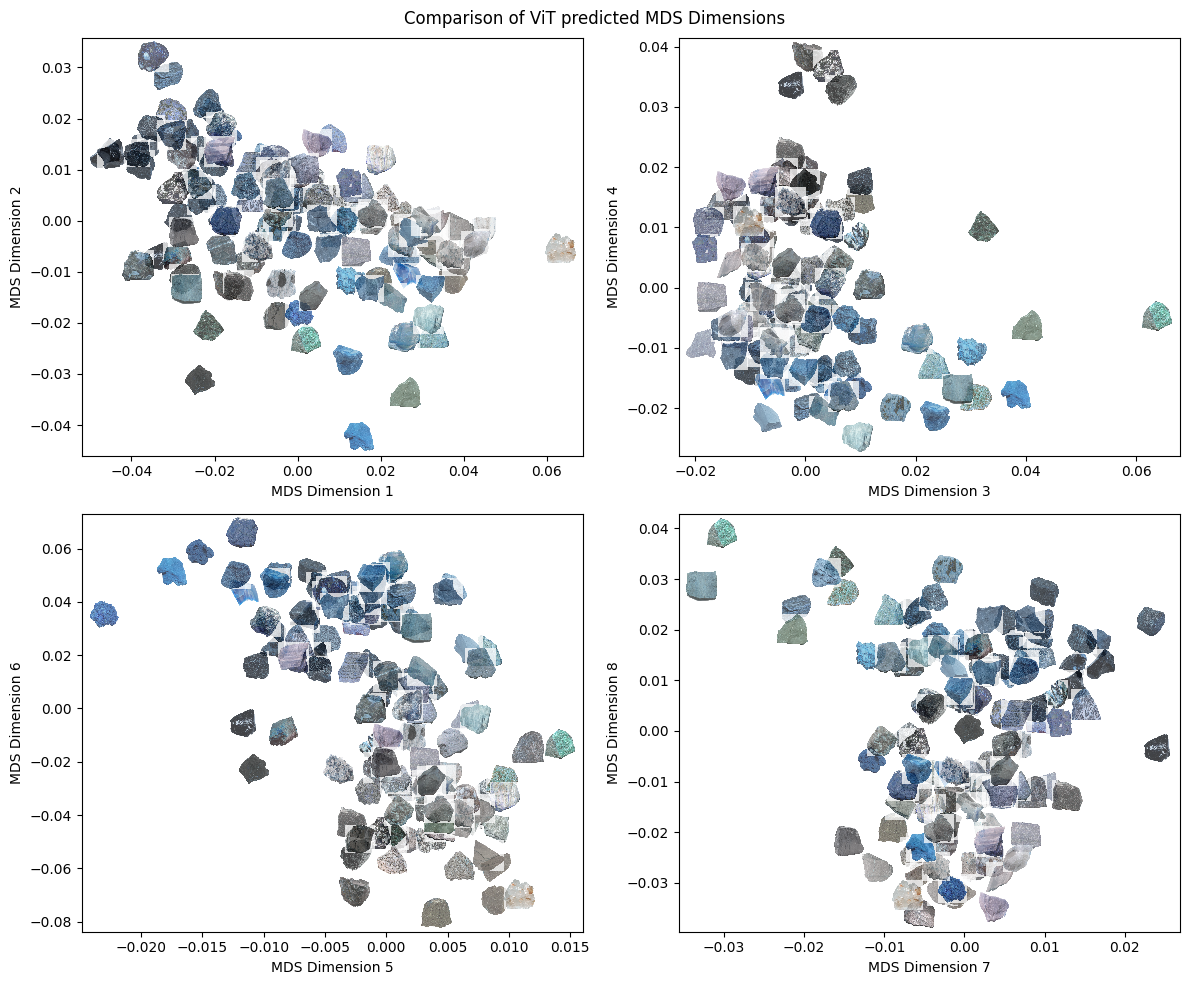

In [23]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from PIL import Image

images = img_120_rgb

mtx1, mtx2, disparity = procrustes(Y_120, activations_120)

mds_coordinates = mtx2

scaled_images = images

def crop_image_color_threshold(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Define lower and upper bounds for white color in BGR format
    lower_white = np.array([200, 200, 200])
    upper_white = np.array([255, 255, 255])
    
    # Create a mask based on the color threshold
    mask = cv2.inRange(img, lower_white, upper_white)
    
    # Invert the mask to get the regions that are not white
    mask = cv2.bitwise_not(mask)
    
    # Find contours of the non-white regions
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get the bounding box of the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image using the bounding box
    cropped_img = img[y:y+h, x:x+w]
    
    return cropped_img


# Create subplots for different pairs of dimensions
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Pairs of dimensions: (0, 1), (2, 3), (4, 5), (6, 7)
dimension_pairs = [(0, 1), (2, 3), (4, 5), (6, 7)]

for i, ax in enumerate(axes.flatten()):
    dimension_x, dimension_y = dimension_pairs[i]
    
    # Scatter plot of MDS coordinates
    ax.scatter(mds_coordinates[:, dimension_x], mds_coordinates[:, dimension_y], alpha=0.01)
    
    # Function to display resized images
    def plot_resized_image(img, x, y, ax):
        img_copy = crop_image_color_threshold(img)
        imagebox = OffsetImage(img_copy, zoom=0.1, alpha = 0.75) 
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)
        
    # Plot each image at its respective MDS coordinates
    for j, (x, y) in enumerate(zip(mds_coordinates[:, dimension_x], mds_coordinates[:, dimension_y])):
        image = scaled_images[j]  # Get the image at index j
        plot_resized_image(image, x, y, ax)
    
    ax.set_xlabel(f'MDS Dimension {dimension_x+1}')
    ax.set_ylabel(f'MDS Dimension {dimension_y+1}')

plt.suptitle(f'Comparison of ViT predicted MDS Dimensions')
plt.tight_layout()
plt.savefig("120 Comp plot.png", dpi=300)
plt.show()

In [56]:
np.mean(correlation_coefficients)

0.5340227933507549

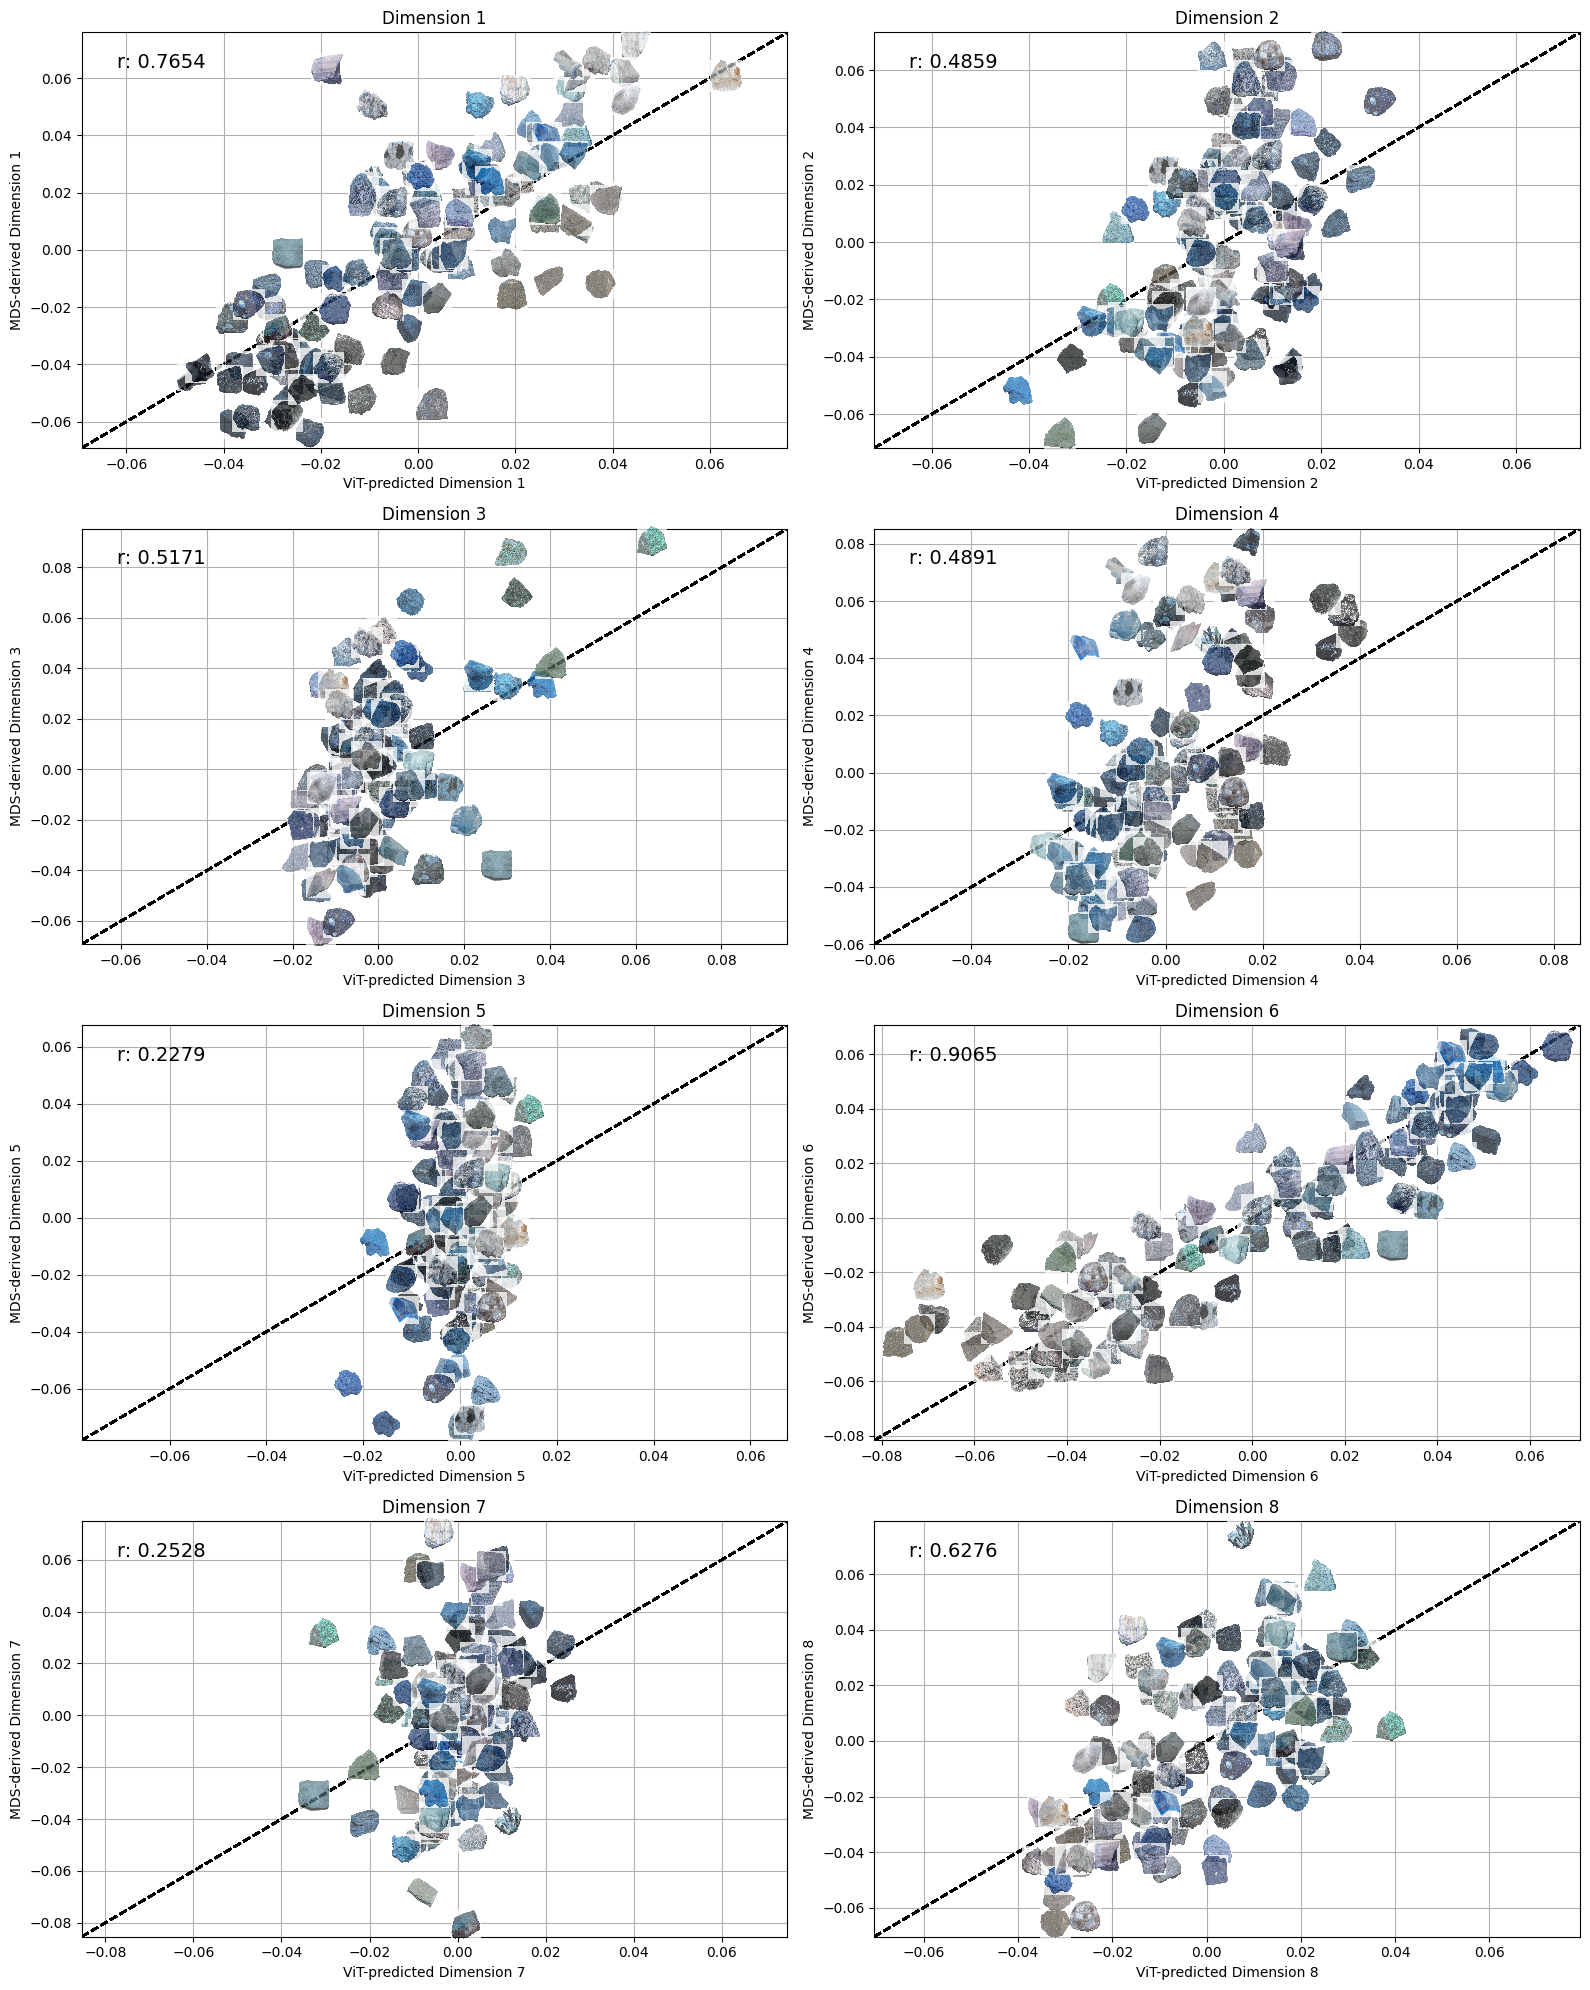

In [59]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from scipy.stats import pearsonr

def crop_image(img):
    # Find non-white pixels along rows
    non_white_rows = np.where(~np.all(img == 255, axis=1))[0]
    # Find non-white pixels along columns
    non_white_cols = np.where(~np.all(img == 255, axis=0))[0]
    # Crop the image using the non-white pixels
    cropped_img = img[non_white_rows.min():non_white_rows.max()+1, non_white_cols.min():non_white_cols.max()+1]
    return cropped_img

def crop_image_color_threshold(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Define lower and upper bounds for white color in BGR format
    lower_white = np.array([200, 200, 200])
    upper_white = np.array([255, 255, 255])
    
    # Create a mask based on the color threshold
    mask = cv2.inRange(img, lower_white, upper_white)
    
    # Invert the mask to get the regions that are not white
    mask = cv2.bitwise_not(mask)
    
    # Find contours of the non-white regions
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get the bounding box of the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image using the bounding box
    cropped_img = img[y:y+h, x:x+w]
    
    return cropped_img

def plot_images_with_coordinates(images, cnn_coordinates, actual_coordinates, correlation_coefficients):
    num_dimensions = cnn_coordinates.shape[1]
    num_images = images.shape[0]
    
    fig, axes = plt.subplots(4, 2, figsize=(16, 20))
    axes = axes.flatten()

    for dim_index in range(num_dimensions):
        ax = axes[dim_index]
        ax.set_title(f"Dimension {dim_index+1}")

        # Get the coordinates for the current dimension
        cnn_coords_dim = cnn_coordinates[:, dim_index]
        actual_coords_dim = actual_coordinates[:, dim_index]

        ax.set_xlabel(f'ViT-predicted Dimension {dim_index+1}')
        ax.set_ylabel(f'MDS-derived Dimension {dim_index+1}')
        ax.grid(True)

        # Dynamically adjust x and y limits based on MDS coordinates
        x_min, x_max = min(cnn_coords_dim.min(), actual_coords_dim.min())-0.005, max(cnn_coords_dim.max(), actual_coords_dim.max())+0.005
        y_min, y_max = min(cnn_coords_dim.min(), actual_coords_dim.min())-0.005, max(cnn_coords_dim.max(), actual_coords_dim.max())+0.005
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # Plot images with coordinates for the current dimension
        for image_index in range(num_images):
            x = cnn_coords_dim[image_index]
            y = actual_coords_dim[image_index]
            img = images[image_index]

            # Crop the image to remove white borders
            img = crop_image(img)

            # Display the image
            imagebox = OffsetImage(img, zoom=0.1, alpha = 0.75)  # Adjust the zoom factor as needed
            ab = AnnotationBbox(imagebox, (x, y), frameon=False)
            ax.add_artist(ab)
            
            # Add a line at 45 degrees
            ax.plot([x_min, x_max], [y_min, y_max], color='black', linestyle='--')

        # Adjusted position of text to top-left corner
        ax.text(0.05, 0.95, f"r: {correlation_coefficients[dim_index]:.4f}", ha='left', va='top', transform=ax.transAxes, fontsize=14)

    plt.tight_layout()
    plt.savefig("120 Corr plot.png", dpi=300)
    plt.show()

# Placeholder for images (replace this with your actual image data)
images = img_120_rgb

# Placeholder for correlation coefficients (replace this with your actual data)
correlation_coefficients = [pearsonr(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i])[0] for i in range(8)]

# Plotting images with coordinates
plot_images_with_coordinates(images, mds_cnn_coordinates, mds_actual_coordinates, correlation_coefficients)


In [71]:
images.shape

(120, 224, 224, 3)

In [73]:
mds_cnn_coordinates.shape

(120, 8)

In [74]:
mds_actual_coordinates.shape

(120, 8)